Summary:
- $(0,1)$ may be predicted if
    - $mnth = 3$ and
        - $0.16 < temp, 0.47 < hum, season = spring$
    - $mnth = 4$ and
        - $0.47 < hum ≤ 0.55$
    - $5 ≤ mnth$ and
        - $temp ≤ 0.44, 0.2 < windspeed$ or
        - $0.44 < temp, 0.62 < hum ≤ 0.75, weekday ≤ 2$
- $(1,0)$ may be predicted if
    - $2 ≤ weathersit, 4 ≤ weekday, temp ≤ 0.39, 2 ≤ season$

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, dt_feature_importance
from tasks.bike_sharing import make_task

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

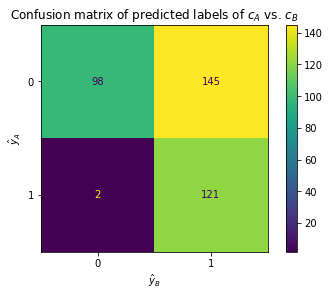

In [5]:
comparer.plot_confusion_matrix(X)

diro2c works with integers only, so I need to scale some features:

In [6]:
scale_features = {'temp': 100, 'windspeed': 100, 'hum': 100, 'atemp': 100}

# Global explanations

In [49]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [72]:
focus_class = '(0, 1)'

In [8]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          scale_features=scale_features,
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 39min 35s, sys: 1min 45s, total: 41min 21s
Wall time: 11min 11s


In [73]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [74]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [75]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [76]:
feature_importances = dt_feature_importance(tree)
feature_order = np.flip(np.argsort(feature_importances))

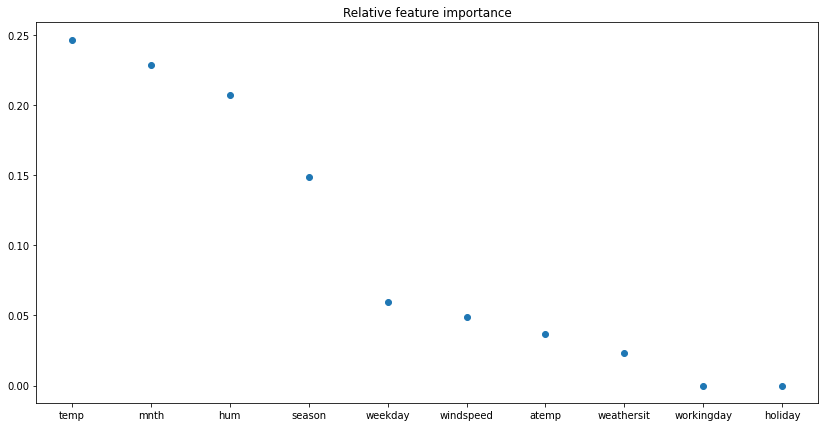

In [77]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [78]:
#fig, ax = plt.subplots(figsize=(42, 28))
#plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [79]:
print_rules(tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #28: if (temp > 0.16) and (mnth <= 3.5) and (hum > 0.47) and (season > 1.5) then class: (0, 1) (591/615 instances)
node #56: if (temp > 0.44) and (mnth > 4.5) and (hum > 0.62) and (hum <= 0.75) and (weekday <= 2.5) then class: (0, 1) (358/546 instances)
node #47: if (temp > 0.25) and (temp <= 0.44) and (mnth > 4.5) and (season > 1.5) and (windspeed > 0.2) then class: (0, 1) (249/279 instances)
node #30: if (mnth > 3.5) and (mnth <= 4.5) and (hum > 0.47) and (hum <= 0.55) and (season > 1.5) then class: (0, 1) (218/261 instances)
node #46: if (temp <= 0.25) and (mnth > 4.5) and (season > 1.5) and (windspeed > 0.2) then class: (0, 1) (126/222 instances)
node #27: if (temp <= 0.16) and (mnth <= 3.5) and (hum > 0.47) and (season > 1.5) then class: (0, 1) (50/99 instances)
node #24: if (mnth > 1.5) and (mnth <= 4.5) and (hum <= 0.47) and (season > 1.5) and (windspeed > 0.23) then class: (0, 1) (57/69 instances)
node #40: if (temp > 0.41) and (temp <= 0.44) and (mnth > 4.5) and (season <

In [80]:
pd.Series(class_names[y_explain]).value_counts()

not (0, 1)    2889
(0, 1)        2596
dtype: int64

In [81]:
(591+358+249+218+126)/2596

0.5939907550077042

With the first 5 rules, the majority of the generated instances classified $(0,1)$ is covered.

In [88]:
indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
pred_nodes = tree.apply(X[indices])
pd.Series(pred_nodes).value_counts()

44    20
56    16
53    15
47    14
6     11
24    11
51     9
59     9
28     8
31     8
57     7
23     6
12     5
60     3
30     2
13     1
dtype: int64

In [87]:
(16+8+14+2+0)/145

0.27586206896551724

Only 28% of the test set instances classified $(0,1)$ are covered by the top 5 rules.

- $mnth ≤ 3$
    - $0.16 < temp, 0.47 < hum, season \neq winter$
- $mnth = 4$
    - $0.47 < hum ≤ 0.55, season \neq winter$
- $5 ≤ mnth$
    - $temp ≤ 0.25, season \neq winter, 0.2 < windspeed$
    - $0.25 < temp ≤ 0.44, season \neq winter, 0.2 < windspeed$
    - $0.44 < temp, 0.62 < hum ≤ 0.75, weekday ≤ 2$ or

Considering, that not all month-season combinations are valid, I can reduced the rules to:

- $mnth = 3$
    - $0.16 < temp, 0.47 < hum, season = spring$
- $mnth = 4$
    - $0.47 < hum ≤ 0.55$
- $5 ≤ mnth$
    - $temp ≤ 0.44, 0.2 < windspeed$ or
    - $0.44 < temp, 0.62 < hum ≤ 0.75, weekday ≤ 2$

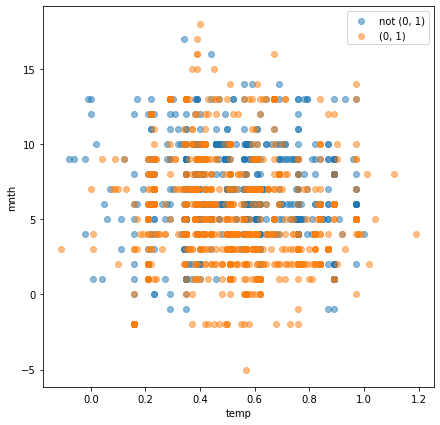

In [16]:
plot_diro2c_2d(explanation, 'temp', 'mnth')

## $(1,0)$

In [36]:
focus_class = '(1, 0)'

In [18]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          scale_features=scale_features,
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 36min 41s, sys: 2min 20s, total: 39min 2s
Wall time: 12min 35s


In [37]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [38]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [39]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [40]:
feature_importances = dt_feature_importance(tree)
feature_order = np.flip(np.argsort(feature_importances))

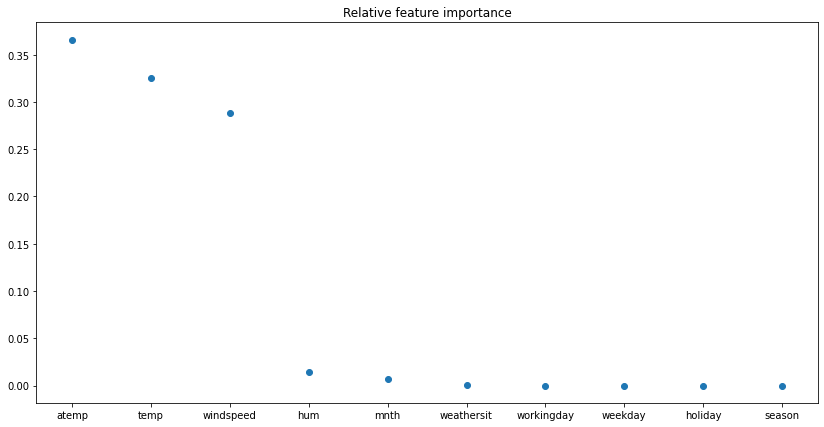

In [41]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

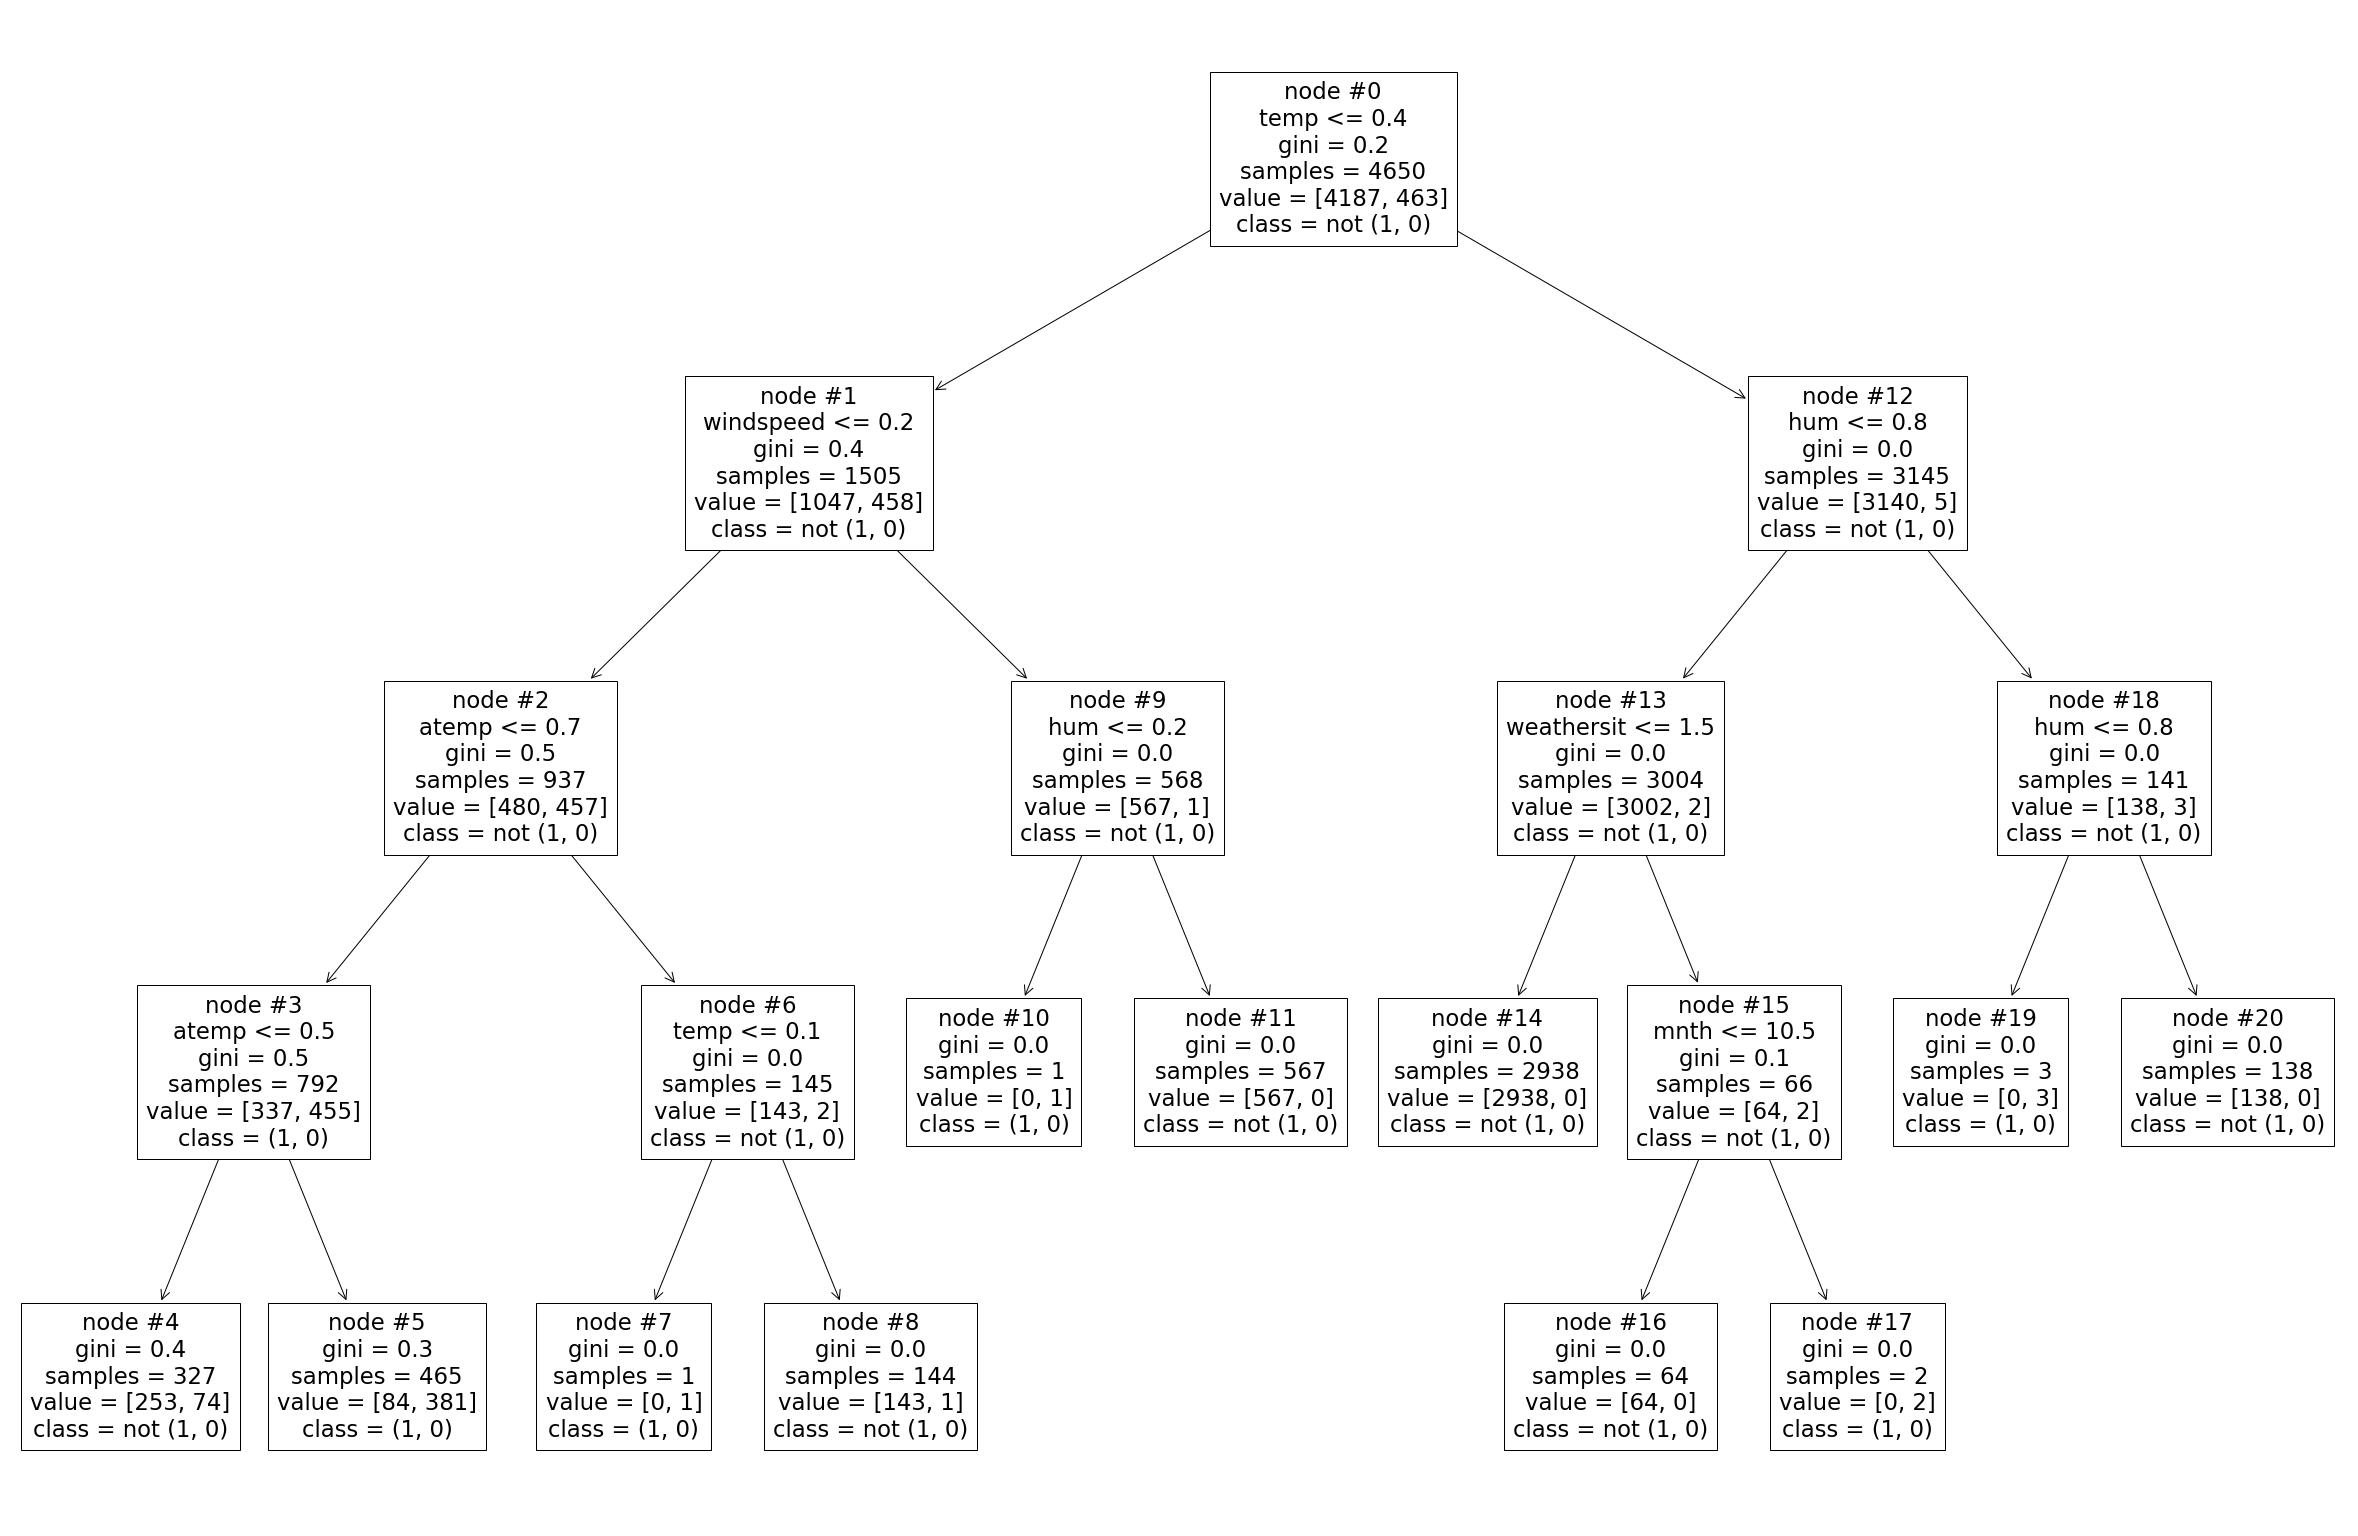

In [42]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [46]:
print_rules(tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #5: if (atemp > 0.52) and (atemp <= 0.66) and (temp <= 0.41) and (windspeed <= 0.19) then class: (1, 0) (381/465 instances)
node #19: if (temp > 0.41) and (hum > 0.83) and (hum <= 0.84) then class: (1, 0) (3/3 instances)
node #17: if (temp > 0.41) and (hum <= 0.83) and (mnth > 10.5) and (weathersit > 1.5) then class: (1, 0) (2/2 instances)
node #10: if (temp <= 0.41) and (windspeed > 0.19) and (hum <= 0.21) then class: (1, 0) (1/1 instances)
node #7: if (atemp > 0.66) and (temp <= 0.1) and (windspeed <= 0.19) then class: (1, 0) (1/1 instances)


In [44]:
pd.Series(class_names[y_explain]).value_counts()

not (1, 0)    4187
(1, 0)         463
dtype: int64

In [45]:
381/463

0.8228941684665226

The first rule applies to 381 instances classified $(1,0)$, which is the majority. 

$0.52 < atemp ≤ 0.66, temp ≤ 0.41, windspeed ≤ 0.19$

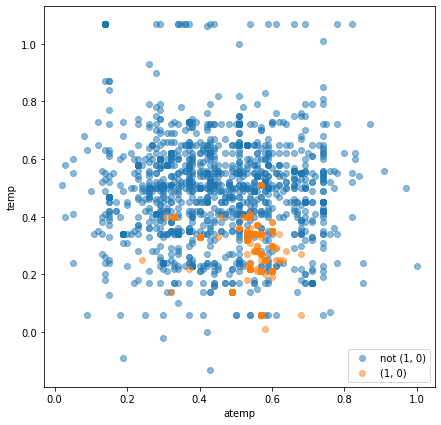

In [26]:
plot_diro2c_2d(explanation, 'atemp', 'temp')

In [54]:
pd.DataFrame(X[comparer.class_names[mclass_diff] == '(1, 0)'], columns=feature_names)

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,4.0,11.0,0.0,4.0,1.0,2.0,0.365833,0.369942,0.581667,0.157346
1,4.0,11.0,0.0,4.0,1.0,2.0,0.321667,0.324492,0.620417,0.152987


Yet the main explanation generated does not apply to the two instances in the test set, they differ by atemp. The other rules also don't cover the two instances.

Maybe a local-only approach is better, since both instances share similar values.

In [57]:
indices = np.where(comparer.class_names[mclass_diff] == '(1, 0)')[0]

In [59]:
idx = indices[0]

In [60]:
%%time
explanation = generate_diro2c_explanation(X, idx, comparer, generation_func='local',
                                          scale_features=scale_features,
                                          focus_class=focus_class, gn_population_size=5000)
with open(f'diro2c.{focus_class}.{idx}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10min 57s, sys: 33.4 s, total: 11min 30s
Wall time: 3min 21s


In [61]:
with open(f'diro2c.{focus_class}.{idx}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [62]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [63]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [64]:
feature_importances = dt_feature_importance(tree)
feature_order = np.flip(np.argsort(feature_importances))

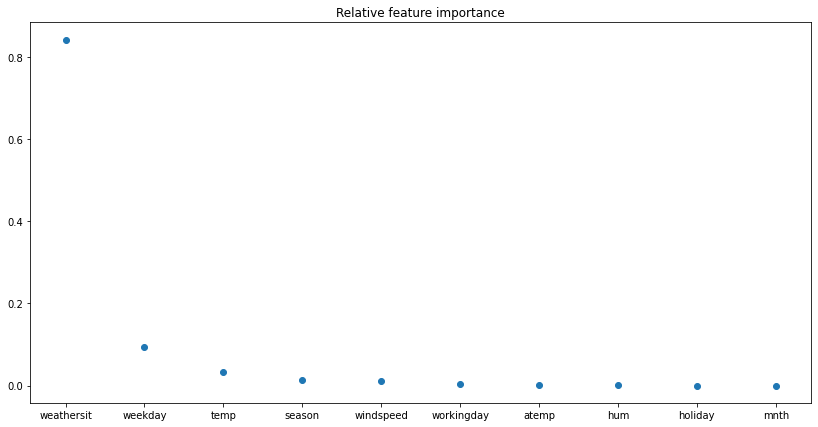

In [65]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

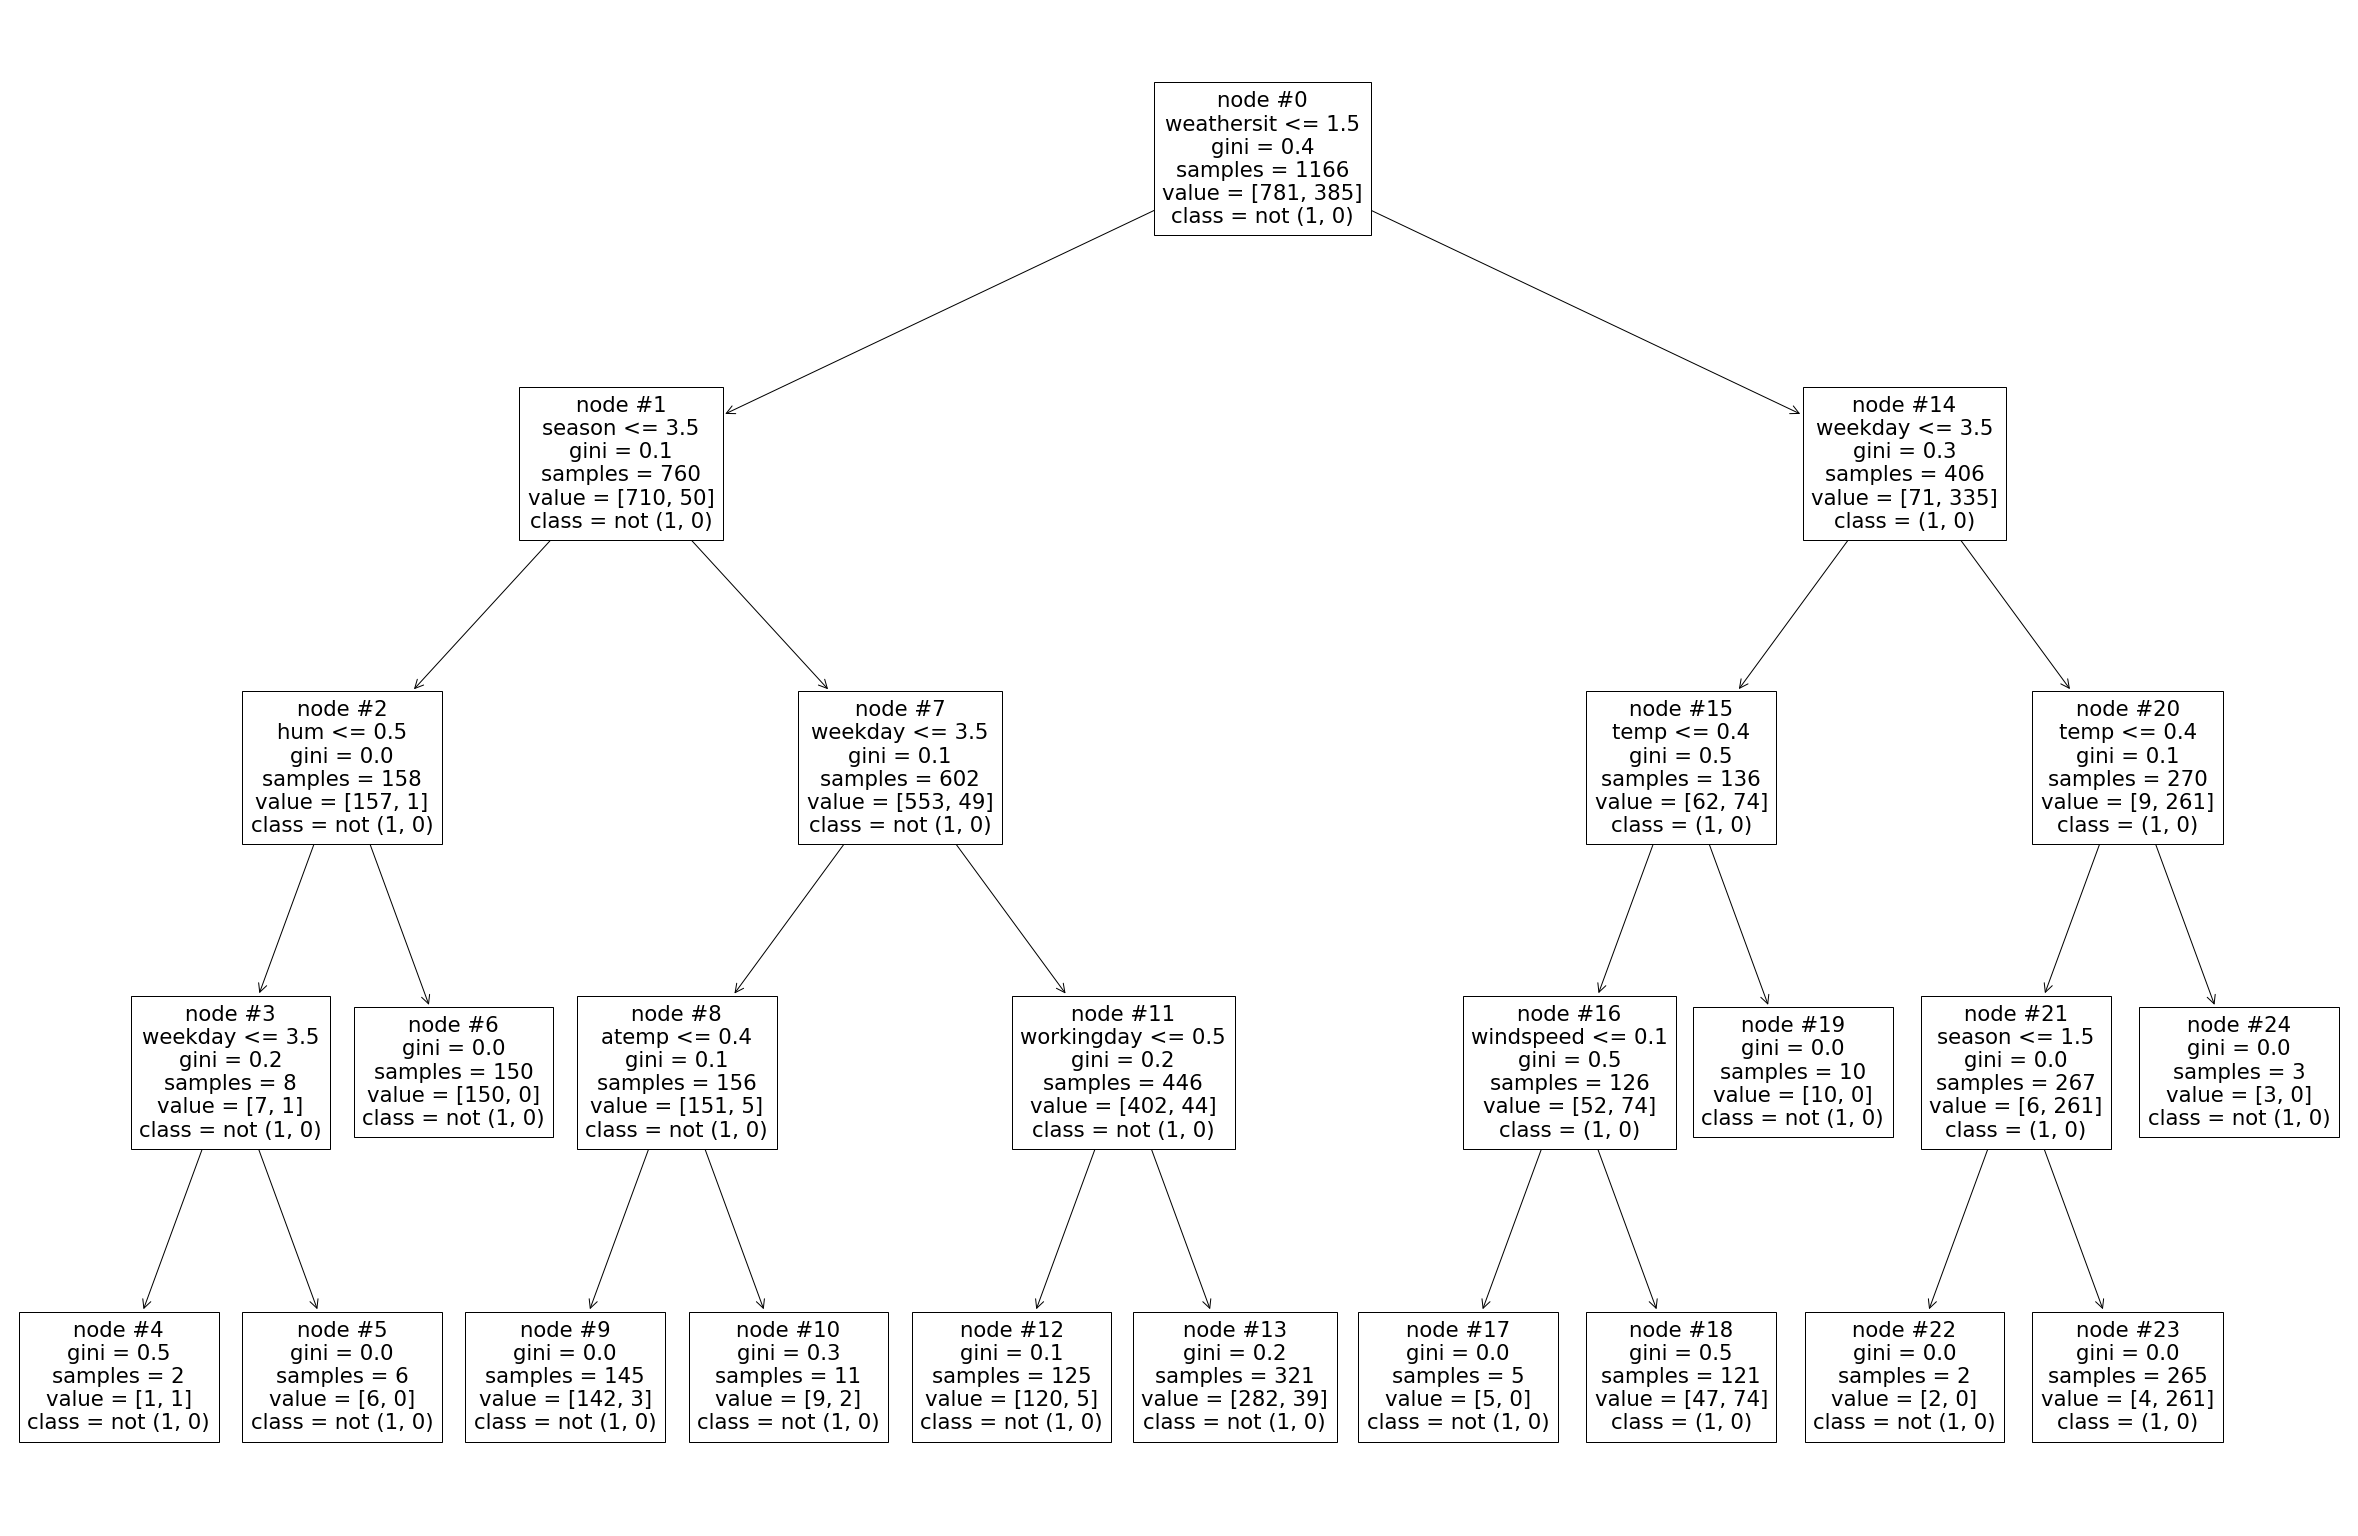

In [66]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [67]:
print_rules(tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #23: if (weathersit > 1.5) and (weekday > 3.5) and (temp <= 0.39) and (season > 1.5) then class: (1, 0) (261/265 instances)
node #18: if (weathersit > 1.5) and (weekday <= 3.5) and (temp <= 0.37) and (windspeed > 0.14) then class: (1, 0) (74/121 instances)


In [68]:
pd.Series(class_names[y_explain]).value_counts()

not (1, 0)    781
(1, 0)        385
dtype: int64

In [71]:
(261)/385

0.6779220779220779

The first rule covers both instances, and the majority of generated instances classified $(1,0)$.

$2 ≤ weathersit, 4 ≤ weekday, temp ≤ 0.39, 2 ≤ season$

In [70]:
tree.apply(X[indices])

array([23, 23])